In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import krippendorff
import os
import seaborn as sns
import numpy as np
from collections import Counter

In [49]:
df = pd.read_json("/shared/3/projects/benlitterer/podcastData/annotation/label1000/annotation_output/annotated300.jsonl", orient="records", lines=True)

In [50]:
stem = "/shared/3/projects/benlitterer/podcastData/annotation/label1000/host_guest_annotation/annotation_output/"
toIgnore = []
folderNames = os.listdir(stem)
folderNames = [item for item in folderNames if "." not in item and item != "archived_users"]

In [51]:

#we actually need to concatenate a bunch of files to get who annotated what  
dfList = []

for fName in folderNames: 
    fPath = stem + fName + "/annotated_instances.jsonl" 
    try: 
        currDf = pd.read_json(fPath, orient="records", lines=True)
        currDf["annotatorId"] = fName
        dfList.append(currDf)
    except: 
        pass
df = pd.concat(dfList)

dictList = list(df["label_annotations"])
labels = [int(list(item["sentiment"].values())[0]) for item in dictList]
df["annotation"] = labels

/tmp/ipykernel_1097109/3674613519.py:7: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  currDf = pd.read_json(fPath, orient="records", lines=True)


In [179]:
#df = pd.read_json("/home/blitt/projects/podcasts/annotation/hostGuestAnnotation/annotation_output/annotated_instances.jsonl", orient="records", lines=True)

In [52]:
df.head() 

,id,displayed_text,label_annotations,span_annotations,behavioral_data,annotatorId,annotation
0,https://anchor.fm/s/1e830af4/podcast/play/1294...,<span style='background-color:#00FF00'>Target ...,{'sentiment': {'host': '1'}},{},{'time_string': 'Time spent: 0d 0h 0m 14s '},663ea7b9da97cba4d63a70ef,1
1,https://traffic.libsyn.com/secure/onthebluelin...,<span style='background-color:#00FF00'>Target ...,{'sentiment': {'host': '1'}},{},{'time_string': 'Time spent: 0d 0h 0m 6s '},663ea7b9da97cba4d63a70ef,1
2,http://dts.podtrac.com/redirect.mp3/static1.sq...,<span style='background-color:#00FF00'>Target ...,{'sentiment': {'guest': '2'}},{},{'time_string': 'Time spent: 0d 0h 0m 34s '},663ea7b9da97cba4d63a70ef,2
3,https://archive.org/download/vuren-special-1-f...,<span style='background-color:#00FF00'>Target ...,{'sentiment': {'neither': '3'}},{},{'time_string': 'Time spent: 0d 0h 1m 13s '},663ea7b9da97cba4d63a70ef,3
4,https://traffic.libsyn.com/secure/tappingqanda...,<span style='background-color:#00FF00'>Target ...,{'sentiment': {'host': '1'}},{},{'time_string': 'Time spent: 0d 0h 2m 49s '},663ea7b9da97cba4d63a70ef,1


In [53]:
#df = df.explode(["label_annotations"]).reset_index(drop=True)
dictList = list(df["label_annotations"])
labels = [int(list(item["sentiment"].values())[0]) for item in dictList]
df["annotation"] = labels

/tmp/ipykernel_1097109/1077187391.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["host", "guest", "neither"])


Text(0.5, 0.98, 'Marginal Distribution of Annotations')

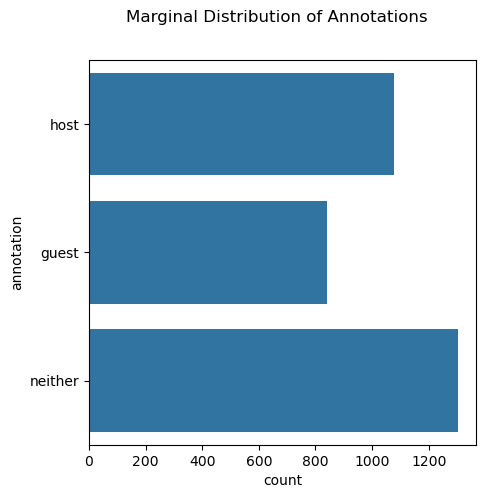

In [54]:
marginalDf = pd.DataFrame(df["annotation"].value_counts()).reset_index()
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(data=marginalDf, x="count", y="annotation", orient="h", ax=ax)
ax.set_yticklabels(["host", "guest", "neither"])
fig.suptitle("Marginal Distribution of Annotations")

In [55]:
#just check and see where we didn't get full assignment 
itemDf = df[["id", "annotation"]].groupby("id").agg(list) 
itemDf["len"] = itemDf["annotation"].apply(len)
itemDf = itemDf.sort_values("len", ascending=True)
itemDf.head() 

,annotation,len
id,,
https://traffic.omny.fm/d/clips/43d4db60-81e7-4097-aef1-a8b300fb00dd/f23698d1-f145-4dae-9e31-a96500e507cd/9b8f7c43-d721-42af-85b0-abbf00eb5ca3/audio.mp3?utm_source=Podcast&in_playlist=c83c2bea-1597-442c-9fcf-a96500e507cd&t=1589811505,"[3, 2]",2
https://archive.org/download/vuren-special-1-final/VurenSpecial1Final.mp3,"[3, 3]",2
https://www.buzzsprout.com/996286/3945002-16-healthcare-and-digitalization-with-bernhard-galleitner.mp3,"[1, 1, 1]",3
https://www.buzzsprout.com/997147/3870086-kate-carlo-perugini-dickens-s-artistic-daughter-katey-and-her-true-love-with-lucinda-hawksley.mp3,"[3, 3, 3]",3
https://www.buzzsprout.com/998860/3752489-corneal-ulcers-in-dogs-cats-and-horses-e9.mp3,"[1, 1, 2]",3


In [99]:
#extract "check" rows
idList = ["https://anchor.fm/s/7f12654/podcast/play/14320049/https%3A%2F%2Fd3ctxlq1ktw2nl.cloudfront.net%2Fstaging%2F2020-4-26%2F76850511-44100-2-e778a17d843dd.m4a",
"https://anchor.fm/s/11028184/podcast/play/14212379/https%3A%2F%2Fd3ctxlq1ktw2nl.cloudfront.net%2Fproduction%2F2020-4-24%2F76170728-44100-2-109d447b04488.mp3",
"https://anchor.fm/s/24044d44/podcast/play/14503148/https%3A%2F%2Fd3ctxlq1ktw2nl.cloudfront.net%2Fstaging%2F2020-4-30%2F78020478-44100-1-1e08e64348a62916.mp3"]

def isCheck(inStr): 
    if "CHECK" in inStr:
        return True
    return False 

checkDf = df[df["id"].apply(isCheck)]


In [100]:
#do we first need to find missing rows and fill them in? 
nonCheckDf = df[df["id"].apply(isCheck) == False]
nonCheckDf.head() 

,id,displayed_text,label_annotations,span_annotations,behavioral_data,annotatorId,annotation
0,https://anchor.fm/s/1e830af4/podcast/play/1294...,<span style='background-color:#00FF00'>Target ...,{'sentiment': {'host': '1'}},{},{'time_string': 'Time spent: 0d 0h 0m 14s '},663ea7b9da97cba4d63a70ef,1
1,https://traffic.libsyn.com/secure/onthebluelin...,<span style='background-color:#00FF00'>Target ...,{'sentiment': {'host': '1'}},{},{'time_string': 'Time spent: 0d 0h 0m 6s '},663ea7b9da97cba4d63a70ef,1
2,http://dts.podtrac.com/redirect.mp3/static1.sq...,<span style='background-color:#00FF00'>Target ...,{'sentiment': {'guest': '2'}},{},{'time_string': 'Time spent: 0d 0h 0m 34s '},663ea7b9da97cba4d63a70ef,2
3,https://archive.org/download/vuren-special-1-f...,<span style='background-color:#00FF00'>Target ...,{'sentiment': {'neither': '3'}},{},{'time_string': 'Time spent: 0d 0h 1m 13s '},663ea7b9da97cba4d63a70ef,3
4,https://traffic.libsyn.com/secure/tappingqanda...,<span style='background-color:#00FF00'>Target ...,{'sentiment': {'host': '1'}},{},{'time_string': 'Time spent: 0d 0h 2m 49s '},663ea7b9da97cba4d63a70ef,1


In [101]:
nonCheckDf = df[df["id"].apply(isCheck) == False]
nonCheckDf.shape
nonCheckDf = nonCheckDf[["annotatorId", "annotation", "id"]].sort_values("annotatorId").groupby("id").agg(list)
nonCheckDf["annotStr"] = nonCheckDf["annotatorId"].apply(lambda x: ",".join(x))

In [ ]:
#get unique, full teams of annotators 
TEAM_SIZE=3
fullAnnotTeams = [item for item in set(nonCheckDf["annotStr"]) if len(item.split(",")) == TEAM_SIZE]
fullAnnotTeams = [item.split(",") for item in fullAnnotTeams]

#this takes any annotator Id 
#and grabs the team that they were a part of 
def getFullAnnotList(inStr): 
    for annotTeam in fullAnnotTeams: 
        if inStr in annotTeam: 
            return annotTeam 

In [108]:
#look at incomplete rows 
incompleteRows = nonCheckDf[nonCheckDf["annotation"].apply(len) < 3]
incompleteIds = list(incompleteRows.index)

print(incompleteRows.iloc[0])
print(incompleteRows.iloc[1])
#get full annotation teams we should have
print(getFullAnnotList(incompleteRows.iloc[0]["annotatorId"][0]))
print(getFullAnnotList(incompleteRows.iloc[1]["annotatorId"][0]))

annotatorId    [663ea7b9da97cba4d63a70ef, 663eba71ccdbc7e24a7...
annotation                                                [3, 3]
annotStr       663ea7b9da97cba4d63a70ef,663eba71ccdbc7e24a72ad73
Name: https://archive.org/download/vuren-special-1-final/VurenSpecial1Final.mp3, dtype: object
annotatorId    [66316beef88431620ea43fee, 663ea133a2b25b50d10...
annotation                                                [3, 2]
annotStr       66316beef88431620ea43fee,663ea133a2b25b50d1078fc2
Name: https://traffic.omny.fm/d/clips/43d4db60-81e7-4097-aef1-a8b300fb00dd/f23698d1-f145-4dae-9e31-a96500e507cd/9b8f7c43-d721-42af-85b0-abbf00eb5ca3/audio.mp3?utm_source=Podcast&in_playlist=c83c2bea-1597-442c-9fcf-a96500e507cd&t=1589811505, dtype: object
['65a84bcfd24dfc3650843923', '663ea7b9da97cba4d63a70ef', '663eba71ccdbc7e24a72ad73']
['5cd0a1a291c2aa00010c7c92', '66316beef88431620ea43fee', '663ea133a2b25b50d1078fc2']


In [90]:


def fillMissingAnnot(inRow): 
    annotStr = inRow["annotStr"]
    if len(annotStr.split(",")) == TEAM_SIZE: 
        return inRow
    else: 
        #get the full team of annotators we should have, and fill in 
        #our actual annotations so we have a full set in the right order 
        currAnnots = inRow["annotatorId"]
        currAnnotations = inRow["annotation"]
        fAnnot = annotStr.split(",")[0]
        fTeam = getFullAnnotList(fAnnot)
        outRow = [[],[],""]
        annotIter = 0 
        print(fTeam)
        for i, annotator in enumerate(fTeam): 

            outRow[0].append(annotator)
            if i > 0: 
                outRow[2] += f",{annotator}"
            else: 
                outRow[2] += annotator
            
            #if we arrive at a missing annotation 
            if annotator not in currAnnots: 
                outRow[1].append(np.nan)
            else: 
                outRow[1].append(currAnnotations[annotIter])
                annotIter += 1
        
        return outRow

#this is the filled-in version of nonCheckDf
nonCheckDfImp = nonCheckDf.apply(fillMissingAnnot, axis=1)



['65a84bcfd24dfc3650843923', '663ea7b9da97cba4d63a70ef', '663eba71ccdbc7e24a72ad73']
['5cd0a1a291c2aa00010c7c92', '66316beef88431620ea43fee', '663ea133a2b25b50d1078fc2']


In [91]:
nonCheckDf

,annotatorId,annotation,annotStr
id,,,
http://awscdn.podcasts.com/Episode-5-Interview-with-Andrea-Bailey-f9f8.mp3,"[57b8e70f35624400013d690c, 5fee5c55878eaa15ebc...","[1, 1, 1]","57b8e70f35624400013d690c,5fee5c55878eaa15ebc56..."
http://awscdn.podcasts.com/What-If-Aang-Hadnt-Disappeared-Right-Before-Sozins-Comet-c0b2.mp3,"[6461e54ee3ce9d9554deda21, 65c17f809c893363dae...","[2, 1, 1]","6461e54ee3ce9d9554deda21,65c17f809c893363dae6b..."
http://bnspodcast.blob.core.windows.net/podcasts/HB_2020_06_02.mp3,"[5efb5360f3f69c084c1ca850, 6151b3079d837c7cd5c...","[3, 3, 3]","5efb5360f3f69c084c1ca850,6151b3079d837c7cd5c80..."
http://cast.rocks/hosting/12797/The-Real-Story-on-Gout.mp3,"[5b6364e153350a0001c0402a, 5d9d5debf3462400144...","[1, 1, 1]","5b6364e153350a0001c0402a,5d9d5debf346240014428..."
http://dts.podtrac.com/redirect.mp3/feeds.soundcloud.com/stream/820232152-humansofhealthcare-021-joseph-thompson-failure-and-resilience.mp3,"[65dd1989214a774c36a0854a, 663b65caecf1e42556b...","[1, 1, 1]","65dd1989214a774c36a0854a,663b65caecf1e42556ba2..."


In [112]:
#visual inspection shows that the na values were imputed properly
#nonCheckDfImp["annotation"].to_list()

In [ ]:

def getNonModal(inRow): 
    counts = Counter(inRow["annotation"])
    modalVal, modeCount = counts.most_common(1)[0]

    return [modalVal, modeCount]

def getNonModalAnnotator(inRow): 
    annots = inRow["annotation"]
    annotators = inRow["annotatorId"]
    mode = inRow["mode"]

    for i, annot in enumerate(annots): 
        if annot != mode: 
            return annotators[i]


def getNonModalAnnotation(inRow): 
    counts = Counter(inRow["annotation"])
    nonMode, nonModeCount = counts.most_common(2)[1]

    return nonMode

In [152]:
nonCheckDfImp[["mode", "modeCount"]] = nonCheckDfImp.apply(getNonModal, axis=1).tolist()
twoAgree = nonCheckDfImp[nonCheckDfImp["modeCount"] == 2]
twoAgree["nonModalAnnotator"] = twoAgree.apply(getNonModalAnnotator, axis=1)
twoAgree["nonMode"] = twoAgree.apply(getNonModalAnnotation, axis=1)
twoAgree = twoAgree.dropna(subset=["mode", "nonMode"])

/tmp/ipykernel_1097109/194754051.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twoAgree["nonModalAnnotator"] = twoAgree.apply(getNonModalAnnotator, axis=1)
/tmp/ipykernel_1097109/194754051.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twoAgree["nonMode"] = twoAgree.apply(getNonModalAnnotation, axis=1)


In [153]:
from sklearn.metrics import confusion_matrix
confusion_matrix(twoAgree["mode"], twoAgree["nonMode"])

array([[ 0, 44, 30],
       [40,  0, 27],
       [40, 62,  0]])

In [154]:
reliabilityData = [[], [], []]
for annotList in nonCheckDfImp["annotation"].to_list(): 
    for i, currAnnot in enumerate(annotList): 
        if currAnnot == currAnnot: 
            reliabilityData[i].append(int(currAnnot)) 
        else: 
            reliabilityData[i].append(currAnnot) 


#but we actually want this to be a list of strings 
#reliabilityData = [" ".join(item) for item in reliabilityData] 


In [155]:
#reliabilityData

In [130]:
#itemDf[["r1", "r2", "r3"]] = outAnnots
#reliabilityData = [list(nonCheckDfImp[col]) for col in ["r1", "r2", "r3"]]
krippendorff.alpha(reliability_data=reliabilityData)

0.7663648384019282

In [134]:
#get percentage of 3 agreement, 2 agreement, etc... 
uniqueCounts = nonCheckDfImp["annotation"].apply(lambda x: len(set(x)))
Counter(uniqueCounts)

Counter({1: 734, 2: 244, 3: 22})

In [ ]:

itemDf["modalVal"] = itemDf["annotation"].apply(lambda x: mode(x)[0])

In [138]:
checkDf = checkDf[["id", "annotatorId", "annotation"]].groupby("id").agg(list)


In [139]:
uniqueCounts = checkDf["annotation"].apply(lambda x: len(set(x)))
Counter(uniqueCounts)

Counter({1: 67, 2: 8})

In [147]:


checkDf[["mode", "modeCount"]] = checkDf.apply(getNonModal, axis=1).tolist()
twoAgree = checkDf[checkDf["modeCount"] == 2]
twoAgree["nonModalAnnotator"] = twoAgree.apply(getNonModalAnnotator, axis=1)
twoAgree["nonMode"] = twoAgree.apply(getNonModalAnnotation, axis=1)

/tmp/ipykernel_1097109/821835154.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twoAgree["nonModalAnnotator"] = twoAgree.apply(getNonModalAnnotator, axis=1)
/tmp/ipykernel_1097109/821835154.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twoAgree["nonMode"] = twoAgree.apply(getNonModalAnnotation, axis=1)


In [149]:

from sklearn.metrics import confusion_matrix
confusion_matrix(twoAgree["mode"], twoAgree["nonMode"])

array([[0, 0, 1],
       [1, 0, 3],
       [1, 2, 0]])

/tmp/ipykernel_1097109/3246571741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twoAgree["dummy"] = 1
/tmp/ipykernel_1097109/3246571741.py:3: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  twoAgree = twoAgree[["nonModalAnnotator", "dummy"]].groupby("nonModalAnnotator").agg(sum).reset_index("nonModalAnnotator").sort_values("dummy", ascending=False)


Text(0.5, 0, 'count')

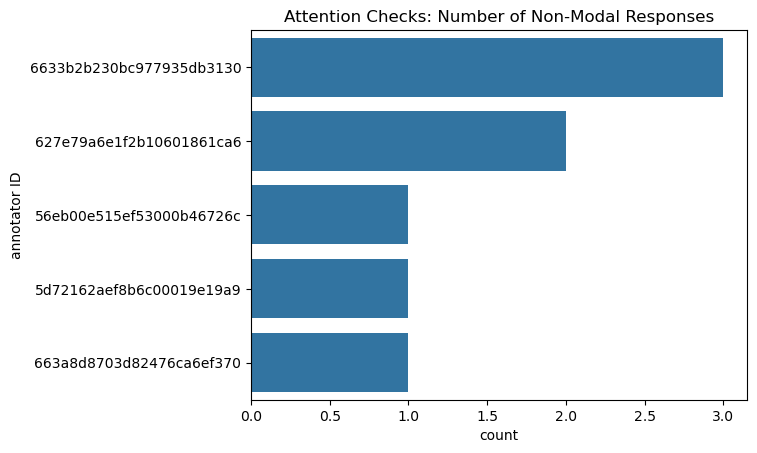

In [146]:
#visualize the non-modal annotators 
twoAgree["dummy"] = 1
twoAgree = twoAgree[["nonModalAnnotator", "dummy"]].groupby("nonModalAnnotator").agg(sum).reset_index("nonModalAnnotator").sort_values("dummy", ascending=False) 

sns.barplot(data=twoAgree, x="dummy", y="nonModalAnnotator")
plt.title("Attention Checks: Number of Non-Modal Responses")
plt.ylabel("annotator ID")
plt.xlabel("count")